In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Read in the calibration data
calib_df = pd.read_csv('Huntington_2019_calibration_data.csv')

In [6]:

# Turn EcoliAve_CFU to log base 10
calib_df['EcoliAve_CFU_log10'] = np.log10(calib_df['EcoliAve_CFU'] + 1)
y_calib = calib_df['EcoliAve_CFU_log10'] # target

# Features
calib_df['SQRT_RAIN48'] = np.sqrt(calib_df['AirportRain48W_in'])
calib_df['SQRT_WaveHt'] = np.sqrt(calib_df['WaveHt_Ft']) 
calib_df['Lake_Turb_NTRU_log10'] = np.log10(calib_df['Lake_Turb_NTRU'] + 1)

X_calib = calib_df[['Lake_Temp_C', 'Lake_Turb_NTRU_log10',
                    'SQRT_WaveHt', 'LL_PreDay',
                    'SQRT_RAIN48']]

In [7]:
# Using Ridge Regularization and Cross Validation
model = Ridge()
k_fold = KFold(n_splits=5, shuffle=True, random_state=42)

param_grid = {'alpha': [0.01, 0.1, 1, 10, 100]} 
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=k_fold, scoring='r2')

# Fitting the Model
grid_search.fit(X_calib, y_calib)

print(f"Best hyperparameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_}")

Best hyperparameters: {'alpha': 1}
Best cross-validation score: 0.549298544005425


In [8]:
# Evaulation
best_model = grid_search.best_estimator_
best_model.fit(X_calib, y_calib)

# Coefficient Table 
coefficient_df = pd.DataFrame({ 'Feature': X_calib.columns, 'Fitted Coefficient': best_model.coef_ })
intercept_df = pd.DataFrame({ 'Feature': ['Intercept'], 'Fitted Coefficient': [best_model.intercept_] })
coeff_table = pd.concat([intercept_df, coefficient_df], ignore_index=True)
print("\nModel Coefficients:")
print(coeff_table)

y_calib_pred = best_model.predict(X_calib)

mean_squared_e = mean_squared_error(y_calib, y_calib_pred) 
rmse = np.sqrt(mean_squared_e) 
r2 = r2_score(y_calib, y_calib_pred) 

print("")
print("Evaluation Metrics:")
print(f"\tR Squared:\t\t{r2:.4e}")
print(f"\tRMSE:\t\t\t{rmse:.4e}") 


Model Coefficients:
                Feature  Fitted Coefficient
0             Intercept           -0.037667
1           Lake_Temp_C            0.033331
2  Lake_Turb_NTRU_log10            0.735999
3           SQRT_WaveHt            0.185907
4             LL_PreDay            0.359086
5           SQRT_RAIN48            0.441836

Evaluation Metrics:
	R Squared:		5.5559e-01
	RMSE:			4.2437e-01


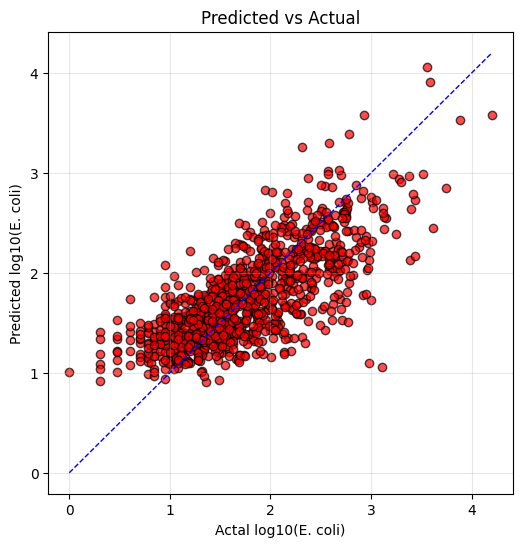

In [18]:
# Plot
plt.figure(figsize=(6,6))
plt.scatter(y_calib, y_calib_pred, alpha=0.7, color='red', edgecolors='k')
lims = [min(y_calib.min(), y_calib_pred.min()), max(y_calib.max(), y_calib_pred.max())]
plt.plot(lims, lims, 'b--', linewidth=1) 
plt.xlabel("Actal log10(E. coli)")
plt.ylabel("Predicted log10(E. coli)")
plt.title("Predicted vs Actual")
plt.grid(True, alpha=0.3)
plt.show()

In [10]:
# (Optional) csv table of the values

compare_df = pd.DataFrame({
    'Observed': y_calib.values.flatten(),
    'Predicted': y_calib_pred.flatten()
    
})
compare_df.round(4).to_csv('huntington_observed_vs_predicted.csv')

In [13]:
# Using Validation Data 
valid_df = pd.read_excel('huntington_validation_spreadsheet_2019.xlsx')

# Target 
valid_df['LAB_ECOLI_LOG10'] = np.log10(valid_df['LAB_ECOLI'] + 1)
y_valid = valid_df['LAB_ECOLI_LOG10']

# Features
valid_df['SQRT_RAIN48'] = np.sqrt(valid_df['AirportRain48W_in'])
valid_df['SQRT_WaveHt'] = np.sqrt(valid_df['WaveHt_Ft']) #USGS model uses square root
valid_df['Lake_Turb_NTRU_log10'] = np.log10(valid_df['Lake_Turb_NTRU'] + 1)

X_valid = valid_df[['Lake_Temp_C', 'Lake_Turb_NTRU_log10',
                    'SQRT_WaveHt', 'LL_PreDay',
                    'SQRT_RAIN48']]

In [14]:
from sklearn.impute import SimpleImputer

# Drop rows where y is missing (can't impute target)
y_row = y_valid.notna()
X_valid = X_valid[y_row]
y_valid = y_valid[y_row]

imputer = SimpleImputer(strategy="mean")
imputer.fit(X_calib)

# Transform X_valid (will fill NaNs using training mean)
X_valid_imputed = pd.DataFrame(
    imputer.transform(X_valid),
    columns=X_valid.columns,
    index=X_valid.index
)

In [15]:
# Attempt On Using Validation Data
best_model = grid_search.best_estimator_

y_pred = best_model.predict(X_valid_imputed)
rmse = np.sqrt(mean_squared_error(y_valid, y_pred))
r2 = r2_score(y_valid, y_pred)

print("Evaluation Metrics:")
print(f"\tR Squared:\t\t{r2:.4e}")
print(f"\tRMSE:\t\t\t{rmse:.4e}")

Evaluation Metrics:
	R Squared:		2.8782e-01
	RMSE:			5.6901e-01


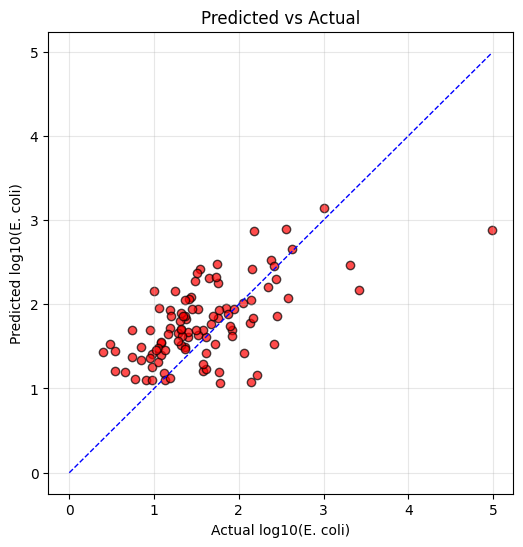

In [17]:
# Plot
plt.figure(figsize=(6,6))
plt.scatter(y_valid, y_pred, alpha=0.7, color='red', edgecolors='k')
lims = [min(y_calib.min(), y_pred.min()), max(y_valid.max(), y_pred.max())]
plt.plot(lims, lims, 'b--', linewidth=1)  # 1:1 line
plt.xlabel("Actual log10(E. coli)")
plt.ylabel("Predicted log10(E. coli)")
plt.title("Predicted vs Actual")
plt.grid(True, alpha=0.3)
plt.show()